In [20]:
import os
from pathlib import Path

import numpy as np
import torch

from matplotlib import pyplot as plt
from matplotlib import patches, patheffects
import cv2

from ssd import build_net
from box import PriorBox
from config import WIDER_300, WIDER_512
from multibox_loss import match_prior_with_truth, cwh2point, point2cwh
from dataset import PedestrianDataset, preproc
from utils import open_image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Viz utils

In [2]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, edgecolor='white', lw=2):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[2:], fill=False, edgecolor=edgecolor, lw=lw))
    draw_outline(patch, 4)

Helper conversion utilities

In [4]:
def cwh2leftwh(boxes):
    return torch.cat((
            boxes[:, :2] - boxes[:, 2:]/2,
            boxes[:, 2:]),
        1)

def point2leftwh(boxes):
    return torch.cat((
            boxes[:, :2],
            boxes[:, 2:] - boxes[:, :2]),
        1)

Data

In [5]:
PATH = Path("/mnt/pedestrian/data/")

train_file = PATH / "train.txt"
train_dir = PATH / "train"
train_annotations = PATH / "train_annotations.txt"
val_file = PATH / "val.txt"
val_dir = PATH / "val"    
    
pedestrian_dataset = PedestrianDataset(PATH,
                                       preproc=preproc(512, (104, 117, 123)))

valpedestrian_dataset = PedestrianDataset(PATH,
                                          train=False,
                                          preproc=preproc(512, (104, 117, 123)))

Generate prior boxes.

I print number of prior boxes from each faeture map. This numbers can be helpfull for visualization.

In [6]:
cfg = WIDER_512
priorbox = PriorBox(cfg)
priors = priorbox.forward()
print(priors.shape)

Feature map 64 bouding box num: (0, 12288)
Feature map 32 bouding box num: (12288, 14336)
Feature map 16 bouding box num: (14336, 14848)
torch.Size([14848, 4])


Function to draw data

In [22]:
def show_img_with_truth(img_id, dataset):
    img = open_image(dataset.train_dir / dataset.files[img_id]) / 255
    ax = show_img(img, figsize=(24, 16))

    height, width, _ = img.shape

    target = dataset[img_id][1]

    for t in point2leftwh(target[:,:-1]):
        t[::2] *= width
        t[1::2] *= height
        draw_rect(ax, t, lw=5)

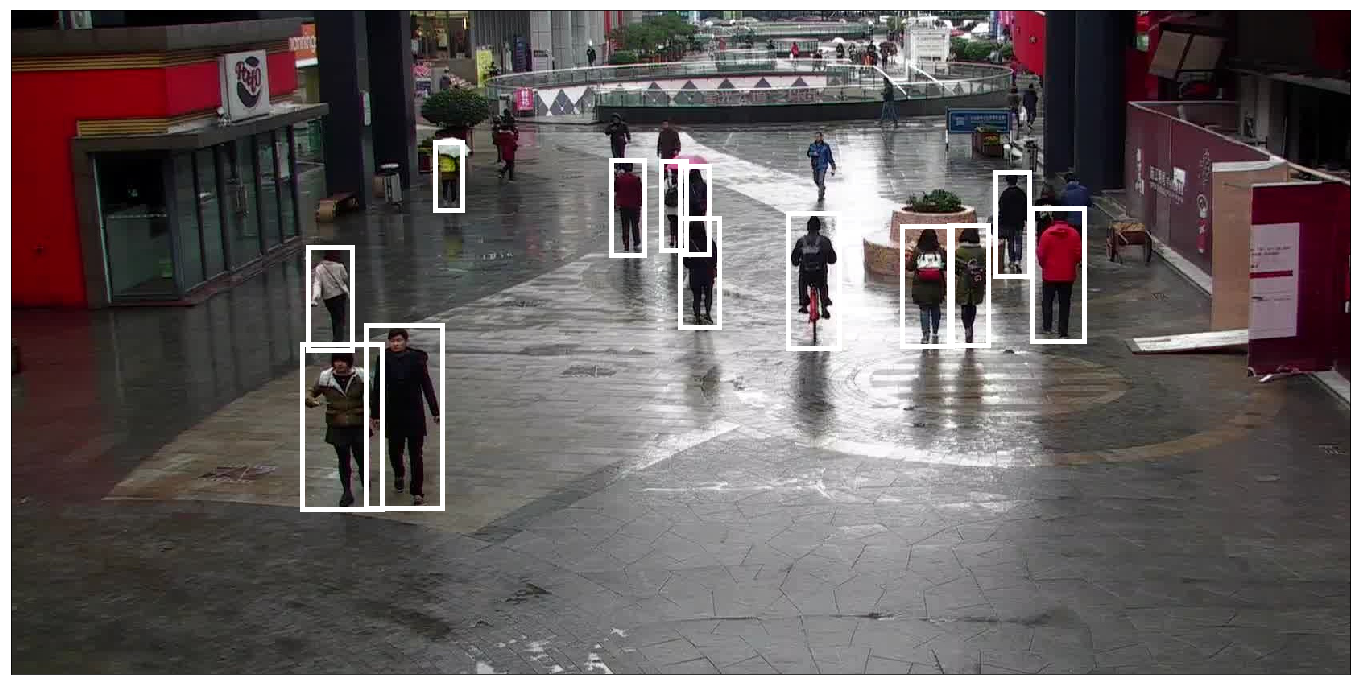

In [23]:
show_img_with_truth(0, pedestrian_dataset)

Function which draws prior boxes.

It is very helful to determine whether prior box are good enough for the task at hand.

In [24]:
def show_img_with_prior(img_id, dataset, prior_ids):
    img = open_image(dataset.train_dir / dataset.files[img_id]) / 255
    ax = show_img(img, figsize=(24, 16))

    height, width, _ = img.shape

    target = dataset[img_id][1]

    for prior_id in prior_ids:
        prior_box = cwh2leftwh(priors)[prior_id]
        prior_box[::2] *= width
        prior_box[1::2] *= height
        draw_rect(ax, prior_box, edgecolor='red', lw=1)

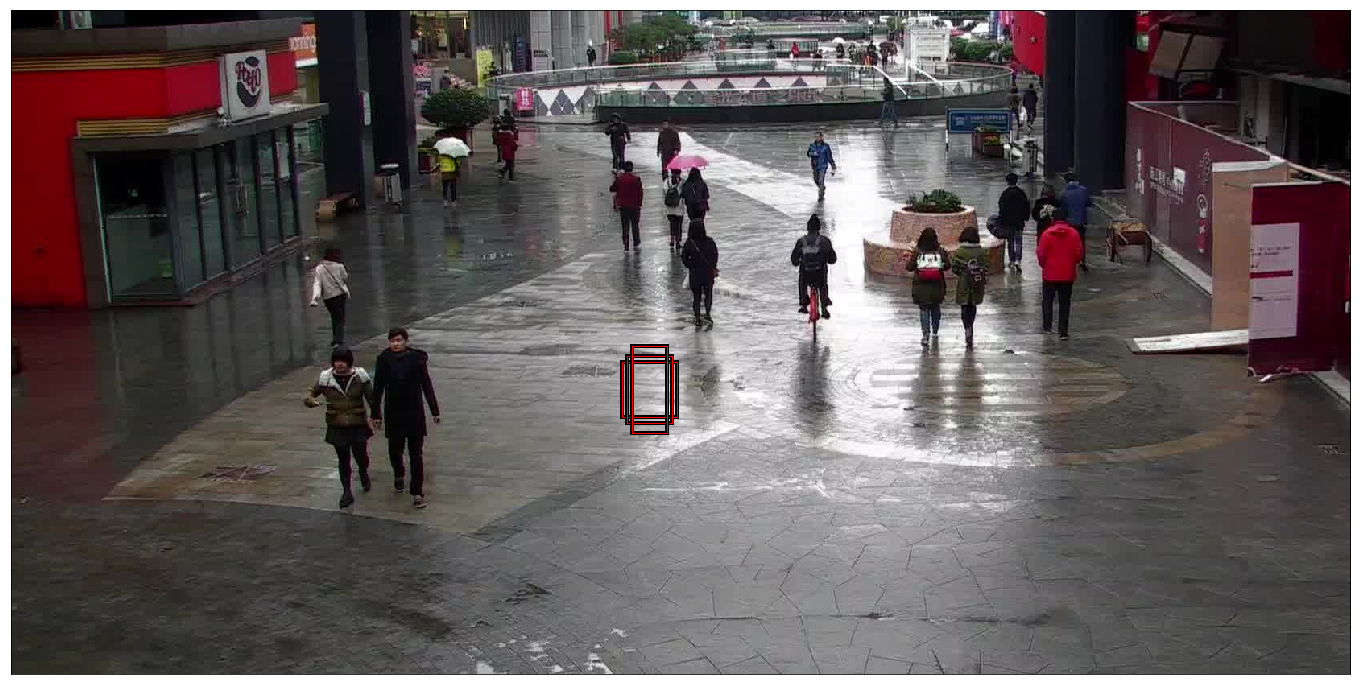

In [25]:
show_img_with_prior(0, pedestrian_dataset, [7002, 7003, 7004])

Network

In [21]:
net = build_net(size=512, num_classes=3)
net.load_state_dict(torch.load("model.th"))
net.eval()

SSD(
  (base): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(256,

In [28]:
def draw_predictions_without_nms(img_id, dataset, net, target_class):

    predictions = net(dataset[img_id][0].unsqueeze(0))
    matched = (predictions[1][0].argmax(dim=1) == target_class).nonzero()

    img = open_image(dataset.train_dir / dataset.files[img_id]) / 255
    ax = show_img(img, figsize=(24, 16))

    height, width, _ = img.shape

    for prior_id in matched:
    
        prior_box = priors[prior_id.item()]
    
        appropriate_prediction = predictions[0][0][prior_id.item()].clone()
        appropriate_prediction[0] = appropriate_prediction[0] * prior_box[2] + prior_box[0]
        appropriate_prediction[1] = appropriate_prediction[1] * prior_box[3] + prior_box[1]
        appropriate_prediction[2] = torch.exp(appropriate_prediction[2]) * prior_box[2]
        appropriate_prediction[3] = torch.exp(appropriate_prediction[3]) * prior_box[3]
    
        appropriate_prediction[::2] *= width
        appropriate_prediction[1::2] *= height
            
        draw_rect(ax, cwh2leftwh(appropriate_prediction.unsqueeze(0))[0], edgecolor='red', lw=1)

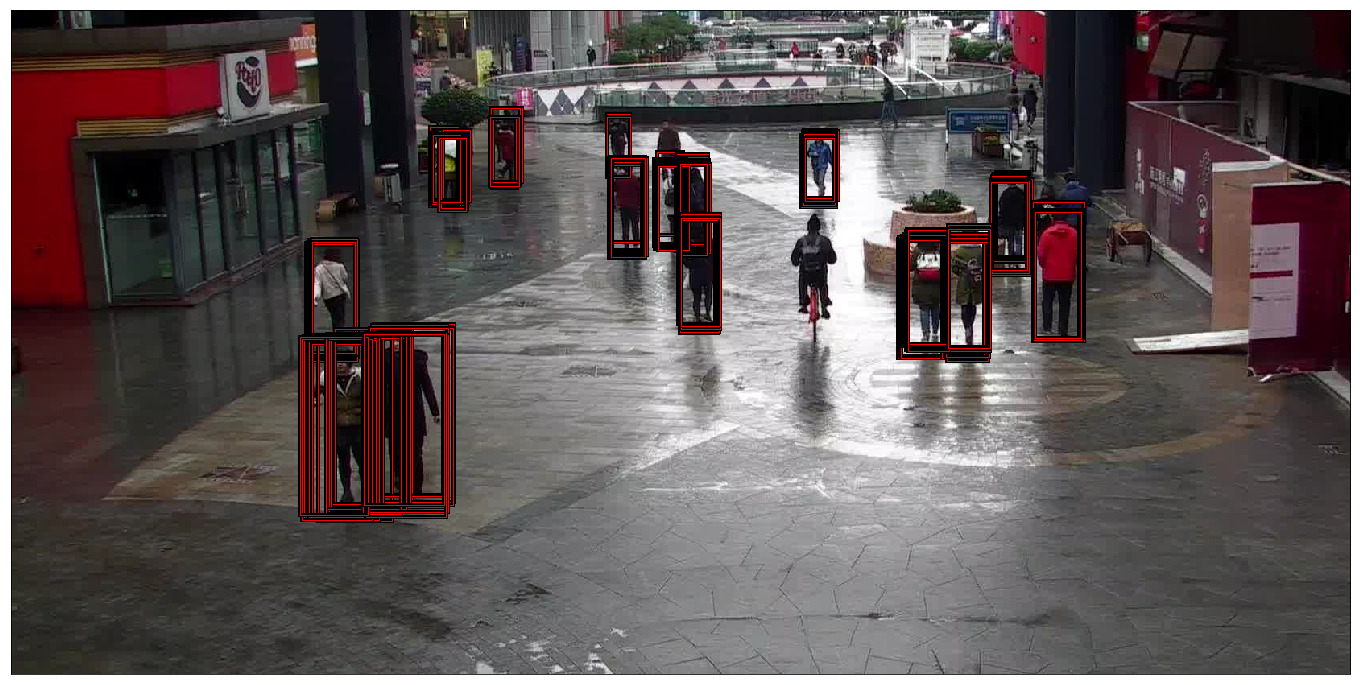

In [29]:
draw_predictions_without_nms(0, pedestrian_dataset, net, 1)

In [30]:
def py_cpu_nms(dets, scores, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [33]:
def draw_predictions_after_nms(img_id, dataset, net, target_class):

    img = open_image(dataset.train_dir / dataset.files[img_id]) / 255
    ax = show_img(img, figsize=(24, 16))

    height, width, _ = img.shape

    predictions = net(dataset[img_id][0].unsqueeze(0))

    matched = (predictions[1][0].argmax(dim=1) == target_class).nonzero()

    boxes = []

    for prior_id in matched:
        prior_box = priors[prior_id.item()]
    
        appropriate_prediction = predictions[0][0][prior_id.item()].clone()
        appropriate_prediction[0] = appropriate_prediction[0] * prior_box[2] + prior_box[0]
        appropriate_prediction[1] = appropriate_prediction[1] * prior_box[3] + prior_box[1]
        appropriate_prediction[2] = torch.exp(appropriate_prediction[2]) * prior_box[2]
        appropriate_prediction[3] = torch.exp(appropriate_prediction[3]) * prior_box[3]
    
        appropriate_prediction[::2] *= width
        appropriate_prediction[1::2] *= height
        
        boxes.append(cwh2point(appropriate_prediction.unsqueeze(0))[0])
        
    if boxes:
        boxes = torch.stack(boxes)
        scores = predictions[1][0][matched].squeeze(1)[:, target_class].data.numpy()
    
        keep = py_cpu_nms(boxes.data.numpy(), scores, 0.45)
    
        for bbox in cwh2leftwh(point2cwh(boxes[keep])):
            draw_rect(ax, bbox, edgecolor='red', lw=1)

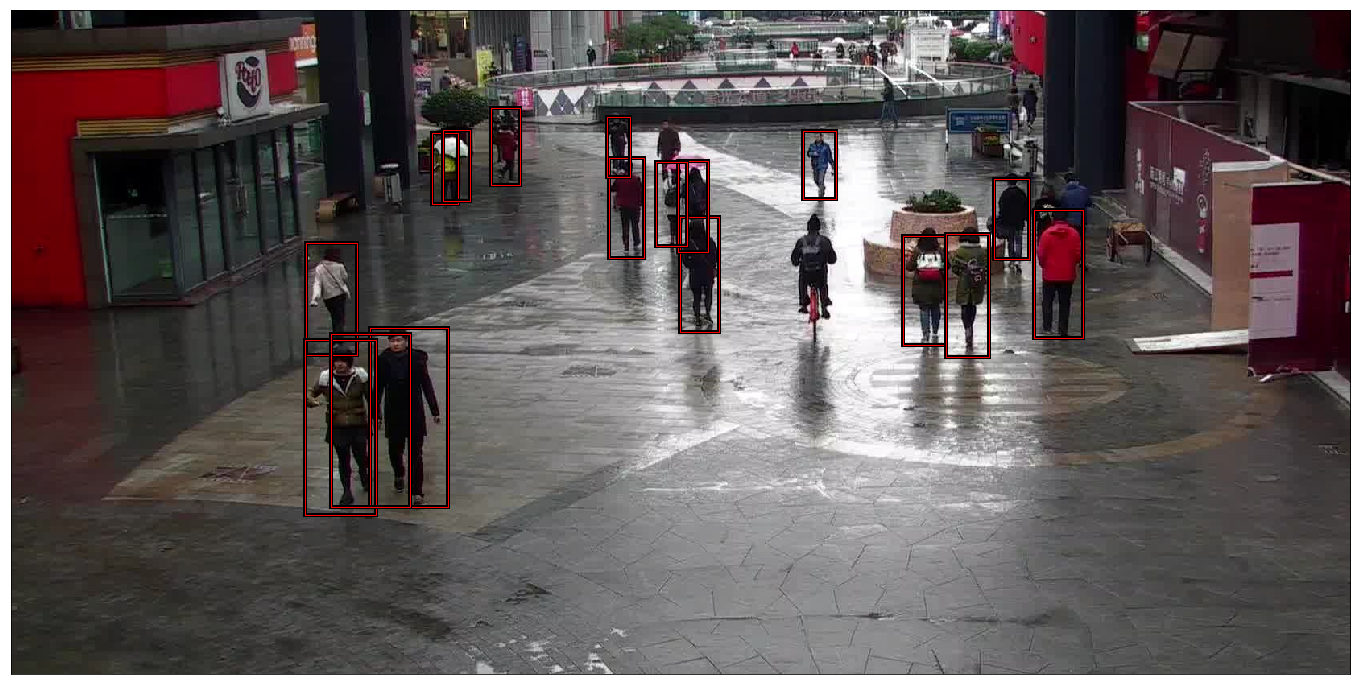

In [34]:
draw_predictions_after_nms(0, pedestrian_dataset, net, 1)

In [ ]:
scores